In [1]:
# Import libraries

import pandas as pd
from scipy import sparse
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
from imblearn.over_sampling import RandomOverSampler 

In [2]:
# Reading the data and storing them as dataframes
features = pd.read_csv('CLEANED_features_output.csv') 
labels = pd.read_csv('labels_output.csv') 

In [3]:
# Vectorize the features and save them as sparse matrices
# This is done for both the title and the content respectively

title_vectorizer = CountVectorizer(ngram_range=(2, 2), analyzer='word')
sparse_matrix_for_title = title_vectorizer.fit_transform(features['title'])
sparse.save_npz("sparse_matrix_for_title.npz", sparse_matrix_for_title)
sparse_matrix_for_title_load = sparse.load_npz("sparse_matrix_for_title.npz")   

In [4]:
content_vectorizer = CountVectorizer(ngram_range=(2, 2), analyzer='word')
sparse_matrix_for_content = content_vectorizer.fit_transform(features['content'])
sparse.save_npz("sparse_matrix_for_content.npz", sparse_matrix_for_content)
sparse_matrix_for_content_load = sparse.load_npz("sparse_matrix_for_content.npz")

In [5]:
# Concatenate the sparse matrices for the title and the content
matrix = hstack([sparse_matrix_for_content_load,sparse_matrix_for_title_load]) 

In [6]:
# Creates the variables X and y for the features and labels respectively
X = matrix 
y = labels 
y = np.ravel(y)

In [7]:
# Split the data into training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=0)

In [8]:
# Oversample the training data to balance the classes and fit the model
oversampler = RandomOverSampler(random_state=0)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

In [9]:
# Creates the model and fits it to the training data, an alpha of 0.1 is used
# To see why, please see the bottom of this notebook for the tuning results

model = ComplementNB(alpha=0.1) 
model.fit(X_train_oversampled, y_train_oversampled)

print(model.score(X_train_oversampled, y_train_oversampled))

0.9988012254140213


In [10]:
predictions_NB = model.predict(X_val)

print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, y_val)*100)

Naive Bayes Accuracy Score ->  74.83062420743657


In [11]:
y_val_pred = model.predict(X_val) 

# Prints the classification report for the validation set
report = classification_report(y_val, y_val_pred)
print("classification report:")
print(report)

classification report:
              precision    recall  f1-score   support

           0       0.76      0.71      0.74     52891
           1       0.74      0.90      0.81    112183
           2       0.77      0.87      0.82     28371
           3       0.69      0.46      0.55      6697
           4       0.81      0.66      0.73     66588
           5       0.75      0.71      0.73     44875
           6       0.45      0.74      0.56      6791
           7       0.37      0.54      0.44      4424
           8       0.50      0.60      0.54     13373
           9       0.97      0.79      0.87     17656
          10       0.78      0.67      0.72     97219

    accuracy                           0.75    451068
   macro avg       0.69      0.70      0.68    451068
weighted avg       0.76      0.75      0.75    451068



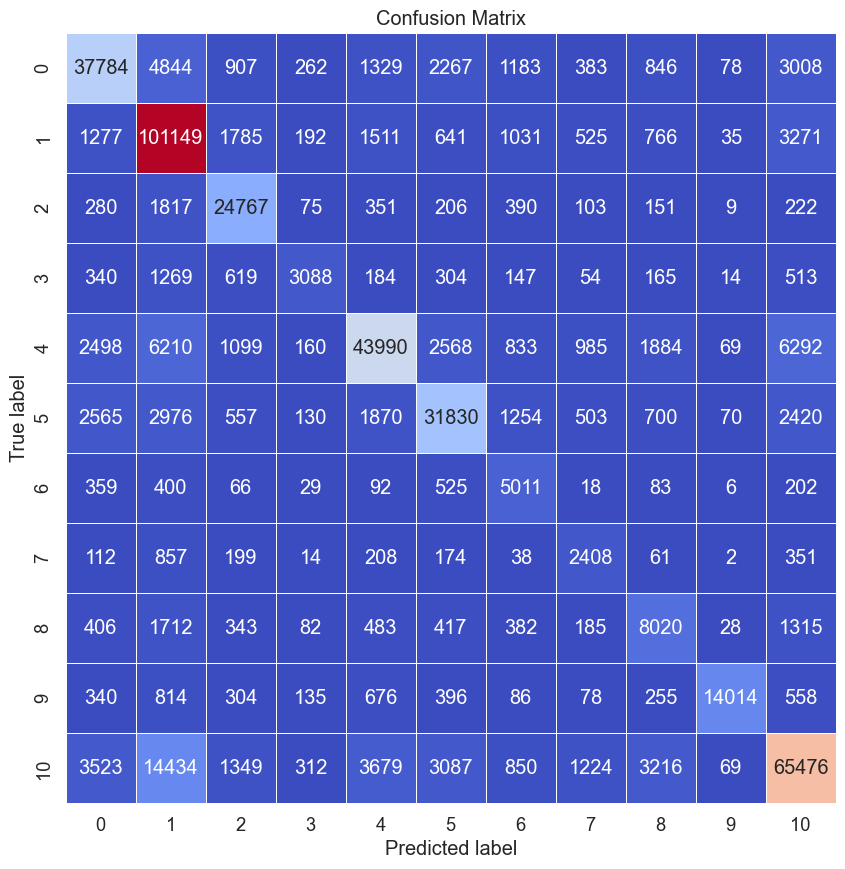

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Set up the plot
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.2)

# Create the heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm', linewidths=0.5, square=True, cbar=False, xticklabels=True, yticklabels=True)

# Customize the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


Tuning

In [13]:
# Define the parameter grid for the grid search
param_grid = [0.00001,0.0001,0.001, 0.01,0.1,1,10,100,1000,10000]

# Initialize the best_C and best_score variables
best_alpha = None
best_score = 0

for pg in param_grid:
    model = ComplementNB(alpha=pg)
    
    model.fit(X_train_oversampled, y_train_oversampled)
    
    y_val_pred = model.predict(X_val)
    
    # Calculate the accuracy score for the current C value
    score = accuracy_score(y_val, y_val_pred)
    
    # Print the current C value and its accuracy score
    print(f"alpha: {pg}, Accuracy: {score}")
    
    # Update the best_C and best_score variables if the current score is higher than the previous best
    if score > best_score:
        best_alpha = pg
        best_score = score
    
# Print the best C value and its accuracy score
print(f"\nBest alpha: {best_alpha}, Best Accuracy: {best_score}")

alpha: 1e-05, Accuracy: 0.7078777479227079
alpha: 0.0001, Accuracy: 0.7143224524905336
alpha: 0.001, Accuracy: 0.7229929855365488
alpha: 0.01, Accuracy: 0.7345078790780991
alpha: 0.1, Accuracy: 0.7483062420743657
alpha: 1, Accuracy: 0.7468253123697536
alpha: 10, Accuracy: 0.7144887245382071
alpha: 100, Accuracy: 0.6741444748907038
alpha: 1000, Accuracy: 0.6284684349144697
alpha: 10000, Accuracy: 0.5763476903704098

Best alpha: 0.1, Best Accuracy: 0.7483062420743657
